# Summary

## BART

# Code

In [ ]:
#@title Installs

!pip install pydot --quiet
!pip install -q transformers==4.37.2

# !pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 29.0 MB/s eta 0:00:00


In [ ]:
#@title Imports

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from transformers import TFBartForSequenceClassification, BartTokenizer

## Load Data

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

# Data Path
train_data_path = '/content/gdrive/My Drive/W266 Final Project/datasets/train_data_binary.csv'
test_data_path = '/content/gdrive/My Drive/W266 Final Project/datasets/test_data_binary.csv'

# Load Raw Data
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

Mounted at /content/gdrive


## Data Overview

In [ ]:
train_data.head()

,Comment,Labels
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
train_data.shape

(159571, 2)

array([[<Axes: title={'center': 'Labels'}>]], dtype=object)

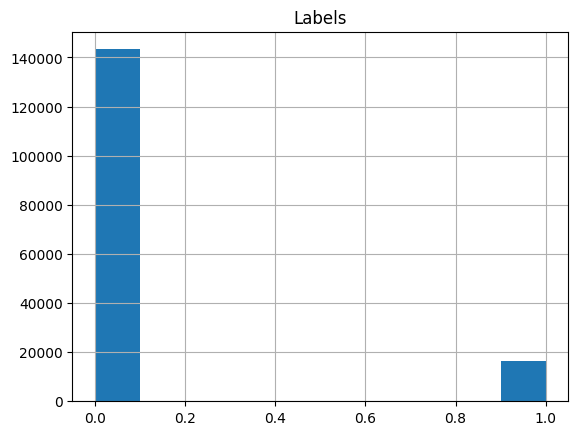

In [ ]:
train_data.hist()

In [ ]:
train_data['Labels'].value_counts()

Labels
0    143346
1     16225
Name: count, dtype: int64

In [ ]:
#random undersampling with the same ratio
#check number of values per class
print("Before random undersampling", train_data['Labels'].value_counts())
# Splitting the data into train and test sets, but in this case, we'll only use the train set
train_subset, _ = train_test_split(train_data, test_size=0.6, random_state=42)

# If you want to reset the index of the subset
train_subset.reset_index(drop=True, inplace=True)
train_under = train_subset
print("After random undersampling", train_under['Labels'].value_counts())

Before random undersampling Labels
0    143346
1     16225
Name: count, dtype: int64
After random undersampling Labels
0    57280
1     6548
Name: count, dtype: int64


In [ ]:
test_data.head()

,Comment,Labels
0,Thank you for understanding. I think very high...,0
1,:Dear god this site is horrible.,0
2,"""::: Somebody will invariably try to add Relig...",0
3,""" \n\n It says it right there that it IS a typ...",0
4,""" \n\n == Before adding a new product to the l...",0


In [ ]:
test_data.shape

(63978, 2)

array([[<Axes: title={'center': 'Labels'}>]], dtype=object)

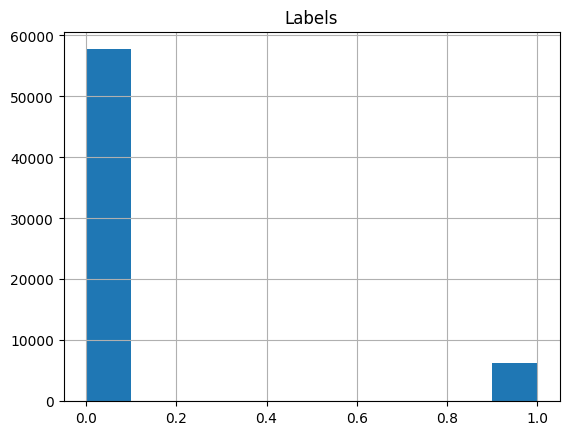

In [ ]:
test_data.hist()

In [ ]:
test_data['Labels'].value_counts()

Labels
0    57735
1     6243
Name: count, dtype: int64

In [ ]:
#random undersampling with the same ratio
#check number of values per class
print("Before random undersampling", test_data['Labels'].value_counts())
# Splitting the data into train and test sets, but in this case, we'll only use the train set
test_subset, _ = train_test_split(test_data, test_size=0.6, random_state=42)

# If you want to reset the index of the subset
test_subset.reset_index(drop=True, inplace=True)
test_under = test_subset
print("After random undersampling", test_under['Labels'].value_counts())

Before random undersampling Labels
0    57735
1     6243
Name: count, dtype: int64
After random undersampling Labels
0    23130
1     2461
Name: count, dtype: int64


## Create train_texts, train_labels, valid_texts, valid_labels, test_texts, and test_labels

In [ ]:
# Splitting the data into train and validation sets
train_data, val_data = train_test_split(train_under, test_size=0.2, random_state=42)

train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

In [ ]:
train_texts = train_data['Comment']
train_texts

0        Christianity is only mentioned three times in ...
1        My Thoughts \n\nYou're a fucking piece of shit...
2        "\nIf you want to customize your userpage, you...
3                          Exactly how are my edits so bad
4        "\n If you'd actually take the time to look ar...
                               ...                        
51057    "\n\nThats not very nice for the people of San...
51058    November 2007 (UTC)\n\nI've been thinking of t...
51059    Track map? \n\nCan a track map be made by jdjo...
51060     "\nOK, but are they ""most"" ? Rajyaमहाराष्ट्र "
51061    William Cooley GA Nomination \n\nHi Horologium...
Name: Comment, Length: 51062, dtype: object

In [ ]:
train_labels = train_data['Labels']
train_labels

0        0
1        1
2        0
3        0
4        0
        ..
51057    0
51058    0
51059    0
51060    0
51061    0
Name: Labels, Length: 51062, dtype: int64

In [ ]:
valid_texts = val_data['Comment']
valid_texts

0        "\n\nFlyer is right, reliable sources are bein...
1        "\n\n Mistake in Map \n\nHello All,\n\nThe map...
2        "\nHi Rjensen. Thanks for getting back to me. ...
3        I have made no changes to the template, only a...
4        Further update: I've now discovered that the C...
                               ...                        
12761    "\n\nAward ceremony dates\nFound a source for ...
12762    Bio means life or living!! \n\nCell isn't mech...
12763    CJ DUB Continues To Insult Wiki Editors & User...
12764    "\nIf only you had followed your own advice a ...
12765    I think we should see what the RFC determines ...
Name: Comment, Length: 12766, dtype: object

In [ ]:
valid_labels = val_data['Labels']
valid_labels

0        0
1        0
2        0
3        0
4        0
        ..
12761    0
12762    0
12763    0
12764    0
12765    0
Name: Labels, Length: 12766, dtype: int64

In [ ]:
test_texts = test_under['Comment']
test_texts

0        Clayton High School \n Hello, I recently remov...
1        " \n\n  Please do not vandalize pages, as you ...
2                                  ::Learn to spell, yank.
3        " \n : As a member of the community, I have re...
4        == Eschew Obfuscation == \n\n If you're intere...
                               ...                        
25586    :Are you proposing something here or opining o...
25587    :I don't think there is sufficient reason to e...
25588    " \n\n == The harm of articles == \n\n Accordi...
25589    " \n\n == Local names 2nd time == \n\n  \n\n Y...
25590                fuckin super gay ass bitch headAlamos
Name: Comment, Length: 25591, dtype: object

In [ ]:
test_labels = test_under['Labels']
test_labels

0        0
1        0
2        0
3        0
4        0
        ..
25586    0
25587    0
25588    0
25589    0
25590    1
Name: Labels, Length: 25591, dtype: int64

## BART-based Classification Models

In [ ]:
model_checkpoint = 'facebook/bart-large'

In [ ]:
bart_tokenizer = BartTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

In [ ]:
max_length = 256

In [ ]:
# Tokenize the dataset
train_encodings = bart_tokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bart_tokenizer(list(valid_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bart_tokenizer(list(test_texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')


In [ ]:
def create_bart_cls_binary_model(checkpoint='facebook/bart-large', max_sequence_length=max_length, learning_rate=0.00001):
    """
    Build a simple classification model using BART for binary classification tasks.
    """
    # Load the BART model for sequence classification with a binary classification head
    bart_model = TFBartForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

    # Define input layers
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='attention_mask')

    # BART model outputs
    outputs = bart_model(input_ids, attention_mask=attention_mask)

    # Output layer, extracting the logits
    logits = outputs.logits

    # Flatten the output tensor to ensure correct input shape to Dense layer
    flatten = tf.keras.layers.Flatten()(logits)

    # Binary classification output head
    classification = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)

    # Define the final model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return model

In [ ]:
bart_model = create_bart_cls_binary_model(checkpoint=model_checkpoint)

tf_model.h5:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBartForSequenceClassification.

Some layers of TFBartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
bart_model_history = bart_model.fit(
    [train_encodings.input_ids, train_encodings.attention_mask], train_labels,
    validation_data=([valid_encodings.input_ids, valid_encodings.attention_mask], valid_labels),
    batch_size=2,
    epochs=2
)

Epoch 1/2
25531/25531 [==============================] - 5165s 198ms/step - loss: 0.1250 - accuracy: 0.9542 - val_loss: 0.1392 - val_accuracy: 0.9380
Epoch 2/2
25531/25531 [==============================] - 5065s 198ms/step - loss: 0.0964 - accuracy: 0.9640 - val_loss: 0.1028 - val_accuracy: 0.9627


800/800 [==============================] - 547s 667ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96     23130
           1       0.56      0.86      0.68      2461

    accuracy                           0.92     25591
   macro avg       0.77      0.89      0.82     25591
weighted avg       0.94      0.92      0.93     25591

ROC AUC Score: 0.9666203057361945


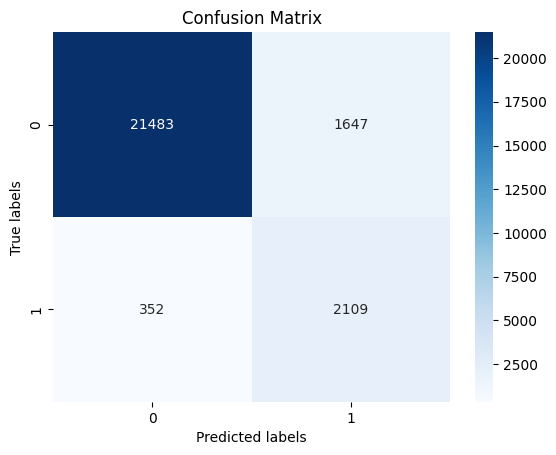

In [ ]:
# Make predictions
predictions = bart_model.predict([test_encodings.input_ids, test_encodings.attention_mask])
predictions = predictions.ravel()

# Convert predictions to binary (0 or 1) based on 0.5 threshold
predictions_binary = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate metrics
print("Classification Report:")
print(classification_report(test_labels, predictions_binary))

print("ROC AUC Score:", roc_auc_score(test_labels, predictions))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
